In [54]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import random
import pygame
import matplotlib.pyplot as plt


In [55]:
#A simple neural network architecture
class genetic_network(nn.Module):
    def __init__(self):
        super().__init__()
        self.architecture= nn.Sequential(
        nn.Linear(9,16),
        nn.Tanh(),
        nn.Linear(16,32),
        nn.Tanh(),
        nn.Linear(32,8),
        )
        self.apply(self._init_weights)
    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            nn.init.uniform_(m.weight, a=-1, b=1)   
    def forward(self,x):
        out = self.architecture(x)
        return out
#A function to get the weights of the nn
def gene(network):
    flat_params = torch.cat([p.view(-1) for p in network.parameters()])
    return flat_params

def set_gene(gene):
    model = genetic_network()
    pointer = 0
    for param in model.parameters():
        numel = param.numel()
        new_values = gene[pointer:pointer+numel].view_as(param)
        with torch.no_grad():
            param.copy_(new_values)
        pointer+=numel
    return model

In [56]:
#Recombination strategies
def recombine_weighted(gene_a,gene_b,alpha):
    return (gene_a*alpha + (1-alpha)*gene_b,gene_b*alpha + (1-alpha)*gene_a)

#def 1 point crossover
def crossover(gene_a,gene_b):
    m = int(len(gene_a) / 2)
    child1 = torch.cat([gene_a[:m], gene_b[m:]], dim=0)
    child2 = torch.cat([gene_b[:m], gene_a[m:]], dim=0)
    return child1, child2

In [ ]:
class Citizen:
    #Initialize citizen
    def __init__(self,start_money,start_x,start_y,speed,skill,type):
        self.food = 0.25
        self.clothes = 0.25
        self.luxury = 0
        self.money = start_money
        self.score = 0
        self.x = start_x
        self.y = start_y
        self.speed = speed
        self.skill = skill
        self.score = 0
        self.type = type #What it does for a living
        self.mind = genetic_network()
    
    #Update citizen actions
    def update(self,taxF,taxT,taxC,delta_time,borderx,bordery):
        #The input to our network
        #We input 9 different values (Taxation F,T,C) , Position(x,y), Inventory(F,C,L) and money
        inp = torch.tensor([taxF,taxT,taxC,self.x/borderx,self.y/bordery,self.food,self.clothes,self.luxury,self.money],dtype=torch.float32)

        #We take a decision (x dir, y_dir, selling price for food,luxuries and clothing , buying price for everything as well)
        self.decision = self.mind(inp)
        #First we want to get a direction to move in
        dirx = float(self.decision[0])
        diry = float(self.decision[1])

        #Normalize the values
        norm = (dirx**2 + diry**2)**0.5
        dirx = dirx/(norm+1e-5)
        diry = diry/(norm+1e-5)

        #Update position of the person
        self.x += dirx*self.speed*delta_time
        self.y += diry*self.speed*delta_time

        if(self.x<0):
            self.x=0
        if(self.y<0):
            self.y =0
        if(self.x>borderx):
            self.x = borderx
        if(self.y>bordery):
            self.y = bordery

    #Update work (People work if they are in a designated working zone)
    def work(self,farm:pygame.Rect,outfitter:pygame.Rect,forge:pygame.Rect,delta_time):
        if(self.type=="farmer"):
            if(farm.collidepoint(self.x,self.y)):
                self.food += self.skill*delta_time
            
        if(self.type=="tailor"):
            if(outfitter.collidepoint(self.x,self.y)):
                self.clothes += self.skill*delta_time

        if(self.type=="smith"):
            if(forge.collidepoint(self.x,self.y)):
                self.luxury += self.skill*delta_time
    #Update happiness
    def updateHappiness(self,food_consumption,clothes_consumption,delta_time):
        if(self.food>0):
            self.score += 0.1*delta_time
            self.food -= food_consumption*delta_time
        else:
            self.score-=0.2*delta_time
        
        if(self.clothes>0):
            self.score += 0.05*delta_time
            self.clothes -= clothes_consumption*delta_time
        else:
            self.score -= 0.1*delta_time
        self.score += 0.01*self.luxury
    #Trading logic ... todo

In [58]:
#Create new genes
#Formula for generating next generation
def generate(group,start_money,min_x,max_x,min_y,max_y):
    group = sorted(group,key=lambda b:b.score,reverse=True)
    new_group = []
    #Add the top 30%performers to the next set of farmers
    for i in range(0,int(0.3*len(group))):
        f = Citizen(start_money,random.randint(min_x,max_x),random.randint(min_y,max_y),group[i].speed,group[i].skill,group[i].type)
        new_group.append(f)

    #Add some recombinations
    while len(new_group)<len(group):
        min_score = min(f.score for f in group)
        chosen_one = random.choices(group, weights=[f.score-min_score for f in group], k=1)[0]
        remaining = [f for f in group if f != chosen_one]
        remaining_weights = [f.score-min_score for f in remaining]
        chosen_two = random.choices(remaining, weights=remaining_weights, k=1)[0]
        gene_a = gene(chosen_one.mind)
        gene_b = gene(chosen_two.mind)
        mutated = crossover(gene_a,gene_b)
        mutated2 = recombine_weighted(gene_a,gene_b,0.4)
        f = Citizen(start_money,random.randint(min_x,max_x),random.randint(min_y,max_y),group[i].speed,chosen_one.skill,chosen_one.type)
        f.mind = set_gene(mutated[0])
        new_group.append(f) 
        f2 = Citizen(start_money,random.randint(min_x,max_x),random.randint(min_y,max_y),group[i].speed,chosen_one.skill,chosen_one.type)
        f2.mind = set_gene(mutated[1])
        new_group.append(f2)
        f = Citizen(start_money,random.randint(min_x,max_x),random.randint(min_y,max_y),group[i].speed,chosen_one.skill,chosen_one.type)
        f.mind = set_gene(mutated2[0])
        new_group.append(f) 
        f2 = Citizen(start_money,random.randint(min_x,max_x),random.randint(min_y,max_y),group[i].speed,chosen_one.skill,chosen_one.type)
        f2.mind = set_gene(mutated2[1])
        new_group.append(f2)
    return new_group

In [59]:
#Simulate the world
pygame.init()
font = pygame.font.SysFont("Arial", 15)
screen = pygame.display.set_mode((850,650))
farm = pygame.Rect(0,0,220,220)
outfitter = pygame.Rect(620,00,220,220)
forge = pygame.Rect(300,400,220,220)

clock = pygame.time.Clock()
farmers = []
tailors = []
smiths = []
#Create farmers
for i in range(0,50):
    farmers.append(Citizen(1,random.randint(200,600),random.randint(0,400),100,0.25,"farmer"))
for i in range(0,50):
    tailors.append(Citizen(1,random.randint(200,600),random.randint(0,400),100,0.25,"tailor"))
for i in range(0,50):
    smiths.append(Citizen(1,random.randint(200,600),random.randint(0,400),100,0.25,"smith"))

running = True
iter = 10
curr = 0
total_time = 0
val_f = []
val_t = []
val_s = []
val = []

while running:

    for event in pygame.event.get():
        if event.type==pygame.QUIT:
            running = False
    screen.fill((255,255,255))
    if(total_time<15):
        # Get delta time in milliseconds
        dt_ms = clock.tick(60)  # Limits frame rate to 60 FPS and returns delta time
        dt_seconds = dt_ms / 1000.0 # Convert to seconds for calculations

        pygame.draw.rect(screen,(0,255,0),farm)
        pygame.draw.rect(screen,(255,0,0),outfitter)
        pygame.draw.rect(screen,(196,164,132),forge)
        
        #Draw all farmers
        for f in farmers:
            f.update(0.1,0.1,0.1,dt_seconds,800,600)
            f.work(farm,outfitter,forge,dt_seconds)
            f.updateHappiness(0.1,0.05,dt_seconds)
            pygame.draw.circle(screen,(0,0,255),(f.x,f.y),10)
            text_surface = font.render(str(round(f.score,1)), True, (0, 0,0))
            screen.blit(text_surface, (f.x, f.y-30))

        for t in tailors:
            t.update(0.1,0.1,0.1,dt_seconds,800,600)
            t.work(farm,outfitter,forge,dt_seconds)
            t.updateHappiness(0.1,0.05,dt_seconds)
            pygame.draw.circle(screen,(0,255,255),(t.x,t.y),10)
            text_surface = font.render(str(round(t.score,1)), True, (0, 0,0))
            screen.blit(text_surface, (t.x, t.y-30))
        for s in smiths:
            s.update(0.1,0.1,0.1,dt_seconds,800,600)
            s.work(farm,outfitter,forge,dt_seconds)
            s.updateHappiness(0.1,0.05,dt_seconds)
            pygame.draw.circle(screen,(255,165,0),(s.x,s.y),10)
            text_surface = font.render(str(round(s.score,1)), True, (0, 0,0))
            screen.blit(text_surface, (s.x, s.y-30))
        total_time += dt_seconds
        
    else:
        curr +=1
        if(curr>iter):
            break
        
        score_f = sum([f.score for f in farmers])
        score_t = sum([t.score for t in tailors])
        score_s = sum([s.score for s in smiths])

        val_f.append(score_f)
        val_t.append(score_t)
        val_s.append(score_s)
        val.append(score_s+score_f+score_t)

        farmers = generate(farmers,1,200,600,0,400)
        tailors = generate(tailors,1,200,600,0,400)
        smiths = generate(smiths,1,200,600,0,400)
        total_time = 0
    #Apply genetic algorithms here
    pygame.display.flip()
               
                   

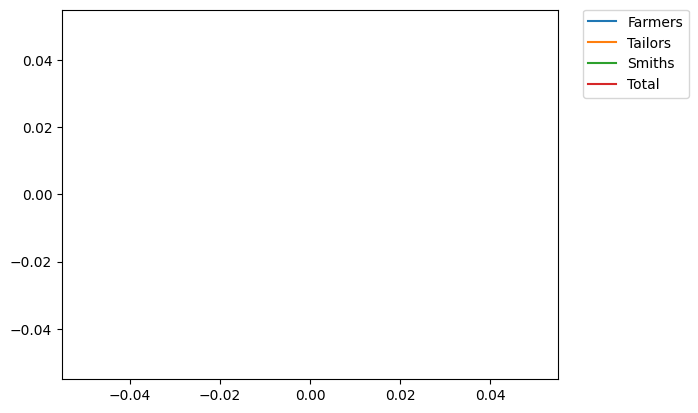

In [60]:
plt.plot(val_f,label="Farmers")
plt.plot(val_t,label="Tailors")
plt.plot(val_s,label="Smiths")
plt.plot(val,label="Total")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)